In [1]:
# Objective: Do some simple ML tasks without using Keras to get a strong
# fondation of the first principles

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

tf.enable_eager_execution()

W0902 16:37:01.466593 140735803462528 __init__.py:690] 

  TensorFlow's `tf-nightly` package will soon be updated to TensorFlow 2.0.

  Please upgrade your code to TensorFlow 2.0:
    * https://www.tensorflow.org/beta/guide/migration_guide

  Or install the latest stable TensorFlow 1.X release:
    * `pip install -U "tensorflow==1.*"`

  Otherwise your code may be broken by the change.

  


In [3]:
### Variables

# Tensors are IMMUTABLE stateless objects. But your ML model needs to have changing state.
# When you model train your mini batches contains different data. The same code to compute prediction
# should behave differently according to the mini-batch

# How to reprent this state which need to change over the course of the operations ? 
# -> Python is a statefull programming language


# Tensor represent the computations, the equation, rather than the the result. A tensor is immutable and stateless

In [7]:
# Example 

x = tf.zeros((10, 10))
x += 2 # Use python state
print(x)

tf.Tensor(
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]], shape=(10, 10), dtype=float32)


In [9]:
# TF also has statefull operations (important to represent weights in a network for instance)

# A Variable is an object which stores a value and, when used in a TensorFlow computation,
# will implicitly read from this stored value. So it has a state, a value 

v = tf.Variable(1.0)
assert v.numpy() == 1.0
print('v: ', v)
print('-'*30)
# Reassign the value of a variable
v.assign(3.0)
assert v.numpy() == 3.0
print('v: ', v)
print('-'*30)

v.assign(tf.square(v))
assert v.numpy() == 9.0
print('v: ', v)
print('-'*30)

# Remember that computations using Variables are automatically traced when computing gradients.
# Using Variables is also a way to quickly let a reader of your code know that this piece of state is mutable.

v:  <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>
------------------------------
v:  <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=3.0>
------------------------------
v:  <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=9.0>
------------------------------
2.0


In [10]:
### Let's build and train a simple model
# 1/ Define the model

# Let's define a class to empasulate the Variables as well as the computation

class Model():
    ''' Class to emcapsulate Variables and the computation
    '''
    def __init__(self):
        # In practice, these should be initialized to random values.
        self.W = tf.Variable(5.0)
        self.b = tf.Variable(0.0)
        
    def __call__(self, x):
        # Return the computation
        return self.W * x + self.b
    
# Define a model
model = Model()

# Verify the correctness of the operation
assert model(3.0).numpy() == 15.0

In [11]:
# 2/ Define a loss function
# Let's use the standard L2 loss

def loss(Y_hat, Y):
    ''' Compute the L2 loss function
    '''
    return tf.reduce_mean(tf.square(Y_hat - Y))

In [13]:
# 3/ Get training data

# Let's synthesize the training data with noise

# Parameters we want our model to learn
TRUE_W = 3.0 
TRUE_B = 2.0

# Number of training examples
M_TRAINING = 1000

inputs = tf.random_normal(shape = [M_TRAINING])
noise = tf.random_normal(shape = [M_TRAINING])
outputs = TRUE_W * inputs + TRUE_B + noise

print('Input[:10]: ', inputs[:10])
print('-'*30)
print('Noise[:10]: ', outputs[:10])
print('-'*30)
print('Output[:10]: ', outputs[:10])

Input[:10]:  tf.Tensor(
[-0.29435527  0.81512433  0.8562746  -1.5440181   0.94921196  0.7814725
 -0.8256014   1.2323823   1.4547889   1.4259715 ], shape=(10,), dtype=float32)
------------------------------
Noise[:10]:  tf.Tensor(
[ 0.08970284  5.545269    4.1221485  -2.7857041   4.8605466   5.591082
 -0.63167757  4.84446     8.027889    6.851552  ], shape=(10,), dtype=float32)
------------------------------
Output[:10]:  tf.Tensor(
[ 0.08970284  5.545269    4.1221485  -2.7857041   4.8605466   5.591082
 -0.63167757  4.84446     8.027889    6.851552  ], shape=(10,), dtype=float32)


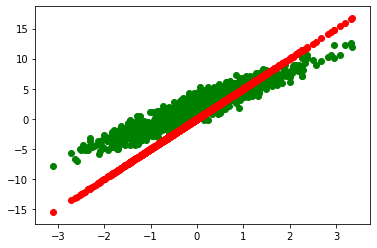

Initial loss function value:  9.18766


In [17]:
# Before training the model, let's see how the model perform on the training set

import matplotlib.pyplot as plt

plt.scatter(inputs, outputs, color = 'green')
plt.scatter(inputs, model(inputs), color = 'red')
plt.show()

print('Initial loss function value: ', loss(model(inputs), outputs).numpy())

In [23]:
# 4/ Train the model

# We'll implement GD by hand to have a better understanding of TF. 
# However in practice use: tf.train.Optimizer so that you don't need to write your optimizer

def update(model, inputs, outputs, learning_rate = 0.1):
    ''' Update the parameters according to Gradient Descent updates
    '''
    with tf.GradientTape() as t:
        current_loss = loss(model(inputs), outputs)
    # Compute the gradient of the cost function
    dW, dB = t.gradient(current_loss, [model.W, model.b]) 
    # Update the parameters
    model.W.assign_sub(learning_rate * dW)
    model.b.assign_sub(learning_rate * dB)
    
def train(model, inputs, outputs, learning_rate = 0.1, epochs = 10):
    ''' Train the model for the given number of epochs. Use batch gradient descent
    '''
    # Keep track of the histories of the paramters W and b
    W_history, b_history = [], []
    for epoch in range(epochs):
        # Update the histories
        W_history.append(model.W.numpy())
        b_history.append(model.b.numpy())
        # Compute the cost function
        current_cost = loss(model(inputs), outputs)
        # Update the parameters
        update(model, inputs, outputs, learning_rate)
        print('EPOCH: %r. Cost function = %r, W = %r, b = %r' %(epoch, current_cost.numpy(), model.W.numpy(), model.b.numpy()))
    
    return W_history, b_history

def plot_parameters_history(W_history, b_history, W_true, b_true):
    ''' Plot the history of the parameters as well as their true value 
    '''
    epochs = len(W_history)
    # There are various ways to plot multiple sets of data.
    plt.plot(range(epochs), W_history, 'r',
             range(epochs), b_history, 'b')
    plt.plot([W_true]*epochs, 'r--',
             [b_true]*epochs, 'b--')
    plt.show()

    

EPOCH: 0. Cost function = 9.18766, W = 4.574404, b = 0.3886164
EPOCH: 1. Cost function = 6.2053595, W = 4.2392626, b = 0.70170254
EPOCH: 2. Cost function = 4.3165526, W = 3.9753149, b = 0.9538983
EPOCH: 3. Cost function = 3.119689, W = 3.7674084, b = 1.157015
EPOCH: 4. Cost function = 2.3609061, W = 3.6036215, b = 1.3205796
EPOCH: 5. Cost function = 1.8796223, W = 3.4745731, b = 1.4522754
EPOCH: 6. Cost function = 1.5742071, W = 3.372881, b = 1.5582969
EPOCH: 7. Cost function = 1.3803062, W = 3.2927344, b = 1.6436381
EPOCH: 8. Cost function = 1.257148, W = 3.2295592, b = 1.7123241
EPOCH: 9. Cost function = 1.1788889, W = 3.1797545, b = 1.7675984
EPOCH: 10. Cost function = 1.1291392, W = 3.1404846, b = 1.8120744
EPOCH: 11. Cost function = 1.0974998, W = 3.1095166, b = 1.8478576
EPOCH: 12. Cost function = 1.0773706, W = 3.0850918, b = 1.8766438
EPOCH: 13. Cost function = 1.0645589, W = 3.0658247, b = 1.8997985
EPOCH: 14. Cost function = 1.0564016, W = 3.0506241, b = 1.9184216
EPOCH: 15. 

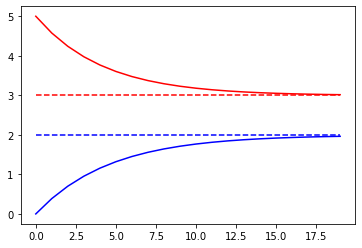

In [25]:
# Let's train the model using the above methods

model = Model()
W_history, b_history = train(model, inputs, outputs, learning_rate=0.1, epochs=20)
plot_parameters_history(W_history, b_history, TRUE_W, TRUE_B)

In [ ]:
### CCL: 
# In theory, this is pretty much all you need to use TensorFlow for your machine learning research.
# In practice, particularly for neural networks, the higher level APIs like tf.keras will be much more convenient